In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import DEVICE, init_random_seeds
from models._utils import (
    print_parameters,
    NaivePredictor,
    LinearRegression,
    FeatureFFNN,
    PureAttention,
    NeuralTransformer,
    NetworkLSTM,
    HippoSSM,
    NetworkCTRNN,
    LiquidCfC,
)

# Initialize the random seeds
init_random_seeds(42)

CUDA device found.


In [2]:
# @title Prepare model and input
# @markdown Make sure the model and input are on the same device.

# Set shapes for model and input
seq_len = 100
input_size = 302
hidden_size = 408

# Use a standard PyTorch model
model = torch.nn.Linear(in_features=input_size, out_features=hidden_size)
model = model.to(DEVICE)
model.eval()  # switch to eval mode
print(f"\nSimple PyTorch model: {model}\n")

# Create input of the correct shape for the model
input = torch.randn(1, seq_len, input_size).to(DEVICE)  # batch_size=1
mask = None
print(f"\nInput: {input.shape} \t Output: {model(input).shape}", end="\n\n")
print(f"\n{'~'*100}\n")

# Load one of our custom models instead
model_args = dict(input_size=input_size, hidden_size=hidden_size, loss="MSE")
# model = NaivePredictor(**model_args)
# model = LinearRegression(**model_args)
# model = FeatureFFNN(**model_args)  # hidden_size = 516 -> num_params = 580286
# model = PureAttention(**model_args)  # hidden_size = 312 -> num_params = 579686
# model = NeuralTransformer(**model_args)  # hidden_size = 196 -> num_params = 583794
# model = NetworkLSTM(**model_args)  # hidden_size = 234 -> num_params = 582260
# model = HippoSSM(**model_args)  # hidden_size = 516 -> num_params = 579770
model = NetworkCTRNN(**model_args)  # hidden_size = 408 -> num_params = 582110
# model = LiquidCfC(**model_args)  # hidden_size = 422 -> num_params = 582368
model = model.to(DEVICE)
model.eval()  # switch to eval mode
print(f"\nCustom model: {model}\n")

# Create input of the correct shape for the model
input = torch.randn(1, seq_len, input_size).to(DEVICE)  # batch_size=1
mask = torch.ones(1, input_size).to(bool).to(DEVICE)
print(
    f"\nInput: {input.shape} \t Mask: {mask.shape} \t Output: {model(input, mask).shape}",
    end="\n\n",
)


Simple PyTorch model: Linear(in_features=302, out_features=408, bias=True)


Input: torch.Size([1, 100, 302]) 	 Output: torch.Size([1, 100, 408])


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Custom model: NetworkCTRNN(
  (identity): Identity()
  (latent_embedding): Linear(in_features=302, out_features=408, bias=True)
  (positional_encoding): Identity()
  (normalization): RMSNorm()
  (input_hidden): Sequential(
    (0): Linear(in_features=302, out_features=408, bias=True)
    (1): Identity()
    (2): RMSNorm()
  )
  (hidden_hidden): CTRNN(
    (input2h): Linear(in_features=408, out_features=408, bias=True)
    (h2h): Linear(in_features=408, out_features=408, bias=True)
  )
  (inner_hidden_model): InnerHiddenModel(
    (hidden_hidden): CTRNN(
      (input2h): Linear(in_features=408, out_features=408, bias=True)
      (h2h): Linear(in_features=408, out_features=408, bias=True)
    )
  )
  (linear_readout): Linear(in_features=408

In [3]:
# @title Profile the model parameters and operations

# Adjust input based on if we use standard PyTorch model or custom model
input = (input, mask) if mask is not None else input

# Count the total and number of trainable parameters
all_params_ct, train_params_ct = print_parameters(model)

print(f"\nAll params: {all_params_ct}\nTrainable params: {train_params_ct}", end="\n\n")

### DEBUG: Find way to compute FLOP using Pytorch Profiler ###


All params: 581702
Trainable params: 581702



Identity()
Linear(in_features=302, out_features=408, bias=True)
RMSNorm()
Sequential(
  (0): Linear(in_features=302, out_features=408, bias=True)
  (1): Identity()
  (2): RMSNorm()
)
CTRNN(
  (input2h): Linear(in_features=408, out_features=408, bias=True)
  (h2h): Linear(in_features=408, out_features=408, bias=True)
)
InnerHiddenModel(
  (hidden_hidden): CTRNN(
    (input2h): Linear(in_features=408, out_features=408, bias=True)
    (h2h): Linear(in_features=408, out_features=408, bias=True)
  )
)
Linear(in_features=408, out_features=302, bias=True)

latent_embedding.weight torch.Size([408, 302])
latent_embedding.bias torch.Size([408])
normalization.weight torch.Size([408])
hidden_hidden.alpha torch.Size([408])
hidden_hidden.input2h.weight torch.Size([408, 408])
hidden_hidden.input2h.bias torch.Size([408])
hidden_hidden.h2h.weight torch.Size([408, 408])
hidden_hidden.h2h.bias torch.Size([408])
linear_readout.weight torch.Size([302, 408])
linear_readout.bias torch.Size([302])



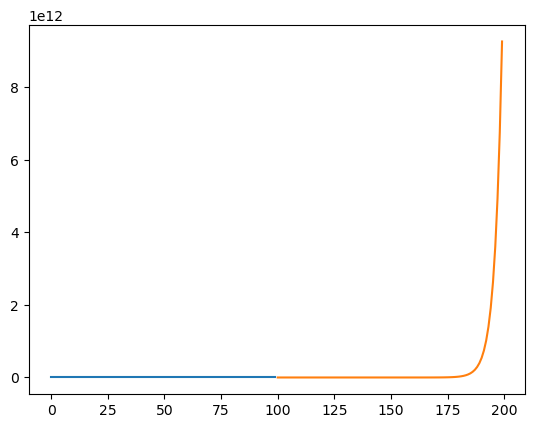

In [4]:
### DEBUG ###

for child in list(model.children()):
    print(child)

print()

for param in list(model.named_parameters()):
    print(param[0], param[-1].shape)

print()

input, mask = input

_ = 100
genout = model.generate(input, mask, _)

plt.plot(np.arange(input.shape[1]), input.squeeze().cpu().numpy()[:, 0])
plt.plot(np.arange(input.shape[1], input.shape[1] + _), genout.squeeze().cpu().numpy()[:, 0])

### DEBUG ###